<span style="font-size:11px">

#### ◆ Bow : Bag of words CountVectorizer
- 문서를 고정된 길이의 벡터로 변환
- 문서 - 단어행렬
- 장점 : 간단하고 빠름
- 단점 : 단어순서 손실, 희소성, 의미적 유사성 무시

#### ◆ TF-IDF : TFidfVectorizer 
- 모든 문서에서 자주 등장하는 단어의 영향을 줄이고, 문서 특이 단어를 강조

#### ◆ Multinomal Naive Bayes 확률 모델
#### ◆ LogisticRegression : 다중클래스 / 회귀기반 분류모델
#### ◆ Ridgeclassifier :  회귀기반 분류 모델 / L2 규제
#### ◆ N-gram : 단점 - 차원폭발에 주의 (정규화/차원 축소 고려)
#### ◆ Konply Okt 사용


In [ ]:
import numpy as np
import pandas as pd
# scikit-learn
from sklearn.datasets import fetch_20newsgroups
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
# https://ndownloader.figshare.com/files/5975967 ===> 바로 다운로드 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
# 분류모델 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
#data load
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', 
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

In [7]:
newsgroups_train.target_names
# alt.atheism : 무신론 관련
# comp.graphics : 그래픽 관련 뉴스
# sci.space : 우주관련
# talk.religion.misc : 일반 종교 이야기

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [30]:
# # 상기 자료 수집에서 타겟 카테고리와 remove가 안되었을 경우
# ### 직접다운 받은 경우 https://ndownloader.figshare.com/files/5975967 

# # 카테고리 제거 : 원하는 자료만 만들기
# def filter_categories(dataset, categories):
#     target_names = newsgroups_train.target_names
#     # target_names.index('comp.graphics')  --> 여기에 target_names 넣으면 인덱스 확인 가능
#     selected_idx = [ target_names.index(c) for c in categories]
#     # selected_idx
#     # 필터링
#     data_filtered, target_filtered = [], []
#     for text, label in zip(newsgroups_train.data, newsgroups_train.target):
#         if label in selected_idx:
#             new_label = selected_idx.index(label) #라벨 재정렬
#             data_filtered.append(text) ; target_filtered.append(new_label)
#     return data_filtered, target_filtered, categories

# train_data, train_target, target_names = filter_categories(newsgroups_train, categories)
# test_data, test_target = filter_categories(newsgroups_test, categories)

# 'headers', 'footers', 'quotes' 삭제
import re

def clean_text(text):
    # 헤더 제거
    text = re.sub(r'^From:.*\n', '', text, flags=re.MULTILINE)
    text = re.sub(r'^Subject:.*\n', '', text, flags=re.MULTILINE)

    # 풋터 제거
    text = re.sub(r'\n--\n.*$', '', text, flags=re.DOTALL)

    # 인용문 제거
    text = re.sub(r'(^|\n)[>|:].*', '', text)

    return text


In [31]:
train_data = [ clean_text(t) for t in newsgroups_train.data ]
test_data = [ clean_text(t) for t in newsgroups_test.data ]
train_target=newsgroups_train.target
test_target=newsgroups_test.target


In [ ]:
train_data

In [32]:
len(train_data), len(train_target), len(test_data), len(test_target)

(2034, 2034, 1353, 1353)

<span style="font-size:11px">

#### 멀티노멀 나이즈베이즈 (Multinomial Naive Bayes)
##### 📘 개념
- 텍스트(문장, 이메일, 뉴스 등)를 **분류할 때 자주 쓰이는 머신러닝 알고리즘**
- **베이즈 (Bayes)** : 확률로 판단하는 방법  
- **나이브 (Naive)** : “순진하다”는 뜻 → 단어들이 서로 영향을 주지 않는다고 **가정**  
- “문서 안의 모든 단어가 서로 독립적으로 등장한다는 순진한 가정 하에, 확률로 분류한다”
- 주요 활용 분야 : **스팸 필터링**, **뉴스 기사 분류**, **감성 분석**
- 기반 이론 : **베이즈 정리 (조건부 확률)**  
  → “단어 A가 나왔을 때, 이 문서가 스팸(B)일 확률은 얼마인가?”를 계산
  
  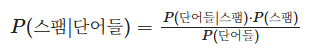

##### 💡 나이브 (Naive)의 의미
- **가정** : 문서 안의 단어들은 서로 독립적 (서로 아무 상관없다)  
- **현실** : 스팸에 자주 나오는 단어들은 서로 연관되어 있음  
- **결과** : 실제로는 완벽히 독립적이지 않아도, 계산이 빠르고 정확도도 꽤 좋음

##### 🎲 멀티노멀 (Multinomial)의 의미
- **단어가 몇 번 등장했는지를 세어 확률을 계산**  
- 단어의 **‘등장 횟수’(빈도)** 를 중요하게 여김  
- NLP(자연어 처리)에서 자주 쓰임 (단어 빈도 기반 모델)  
- 각 카테고리(예: 스팸/정상)에서 단어별 **출현 확률 P(단어|카테고리)** 를 계산

---

#### 🧩 예시
##### 📊 단어 출현 통계
| 단어 | 스팸메일(Spam) | 정상메일(Ham) |
|------|----------------|----------------|
| free | 150 | 10 |
| money | 100 | 5 |
| viagra | 50 | 0 |
| report | 5 | 80 |
| meeting | 2 | 60 |

##### 📧 새로운 문장: `"Free money meeting"`
이 문장이 스팸일까?

1. **스팸일 확률 계산**
   - 기본 스팸확률  
   × P("free" | 스팸)  
   × P("money" | 스팸)  
   × P("meeting" | 스팸)

2. **정상일 확률 계산**
   - 기본 정상확률  
   × P("free" | 정상)  
   × P("money" | 정상)  
   × P("meeting" | 정상)

3. 두 확률을 비교 → **더 높은 쪽이 최종 분류 결과**

---

### 🧠 요약
> 멀티노멀 나이브 베이즈는 **문서 안 단어들의 등장 횟수를 세어**,  
> “이 문서가 어떤 종류일 확률이 더 높은지”를  
> **확률적으로 계산하는 간단하고 빠른 분류 알고리즘**이다.

</span>



In [37]:
# # nltk tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\playdata2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
cv =  CountVectorizer(max_features=2000, min_df=5, max_df = 0.5 )
    # max_features : 전체 단어 중 등장 빈도가 높은 상위 2000개 단어만 사용
    # min_df=5 : 최소 5개 문서(document)에 등장한 단어만 포함 ---> 노이즈 감소
    # max_df = 0.5 : 전체 문서의 50% (0.5) 이상에서 등장하는 단어는 제외
X_train_cv = cv.fit_transform(train_data)
X_test_cv = cv.transform(test_data)
X_train_cv.shape, X_test_cv.shape

((2034, 2000), (1353, 2000))

In [39]:
cv.get_feature_names_out()

array(['00', '000', '01', ..., 'yourself', 'zero', 'zip'],
      shape=(2000,), dtype=object)

In [44]:
X_train_cv[0].toarray()[0]
(X_train_cv[0].toarray()[0])[X_train_cv[0].toarray()[0]>0]

array([1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 6, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1])

In [46]:
# BOW + MNB (BOW 기반의 MNB 모델을 사용함)
# 텍스트 분류의 강력한 baseline / 희소데이터에 강함
nb = MultinomialNB()
# 학습용 데이터 벡터 데이터
nb.fit(X_train_cv, train_target)
print (nb.score(X_train_cv, train_target) , nb.score(X_test_cv, test_target))
# 분류 리포트
from sklearn.metrics import classification_report
y_pred_nb = nb.predict(X_test_cv)
print( classification_report (test_target, y_pred_nb,target_names=categories))



0.8166175024582104 0.7339246119733924
                    precision    recall  f1-score   support

       alt.atheism       0.60      0.65      0.63       319
talk.religion.misc       0.88      0.86      0.87       389
     comp.graphics       0.80      0.77      0.78       394
         sci.space       0.59      0.59      0.59       251

          accuracy                           0.73      1353
         macro avg       0.72      0.72      0.72      1353
      weighted avg       0.74      0.73      0.74      1353



In [48]:
# TF-IDF + MNB + LogisticRegression
  #TF-IDF : 중요단어 강조/ 선형모델과 함께 자주 사용 / BOW 대비 흔한 단어 영향 감소
tfidf = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.5)
X_train_tfidf = tfidf.fit_transform (train_data)
X_test_tfidf = tfidf.transform(test_data)

# MNB
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, train_target)
print ( nb_tfidf.score(X_train_tfidf, train_target), nb_tfidf.score(X_test_tfidf, test_target))
from sklearn.metrics import classification_report
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
print( classification_report (test_target, y_pred_nb_tfidf,target_names=categories))

0.8544739429695182 0.7354028085735402
                    precision    recall  f1-score   support

       alt.atheism       0.58      0.72      0.64       319
talk.religion.misc       0.87      0.89      0.88       389
     comp.graphics       0.76      0.85      0.80       394
         sci.space       0.72      0.33      0.46       251

          accuracy                           0.74      1353
         macro avg       0.73      0.70      0.69      1353
      weighted avg       0.74      0.74      0.72      1353



In [51]:
# LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, train_target)
print (lr.score(X_train_tfidf, train_target), lr.score(X_test_tfidf, test_target))
from sklearn.metrics import classification_report
y_pred_lr_tfidf = lr.predict(X_test_tfidf)
print( classification_report (test_target, y_pred_lr_tfidf,target_names=categories))

0.9213372664700098 0.7354028085735402
                    precision    recall  f1-score   support

       alt.atheism       0.63      0.62      0.62       319
talk.religion.misc       0.79      0.90      0.84       389
     comp.graphics       0.79      0.81      0.80       394
         sci.space       0.67      0.50      0.57       251

          accuracy                           0.74      1353
         macro avg       0.72      0.71      0.71      1353
      weighted avg       0.73      0.74      0.73      1353



In [58]:
# 과적합을 해결하기 위한 규제
rc = RidgeClassifier(alpha=15)
rc.fit(X_train_tfidf, train_target)
print(rc.score(X_train_tfidf, train_target), rc.score(X_test_tfidf, test_target))

0.8387413962635202 0.7087952697708795


In [81]:
# test를 별도로 둬서...?? 상기 score 차이가..?
# LogisticRegression
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 \
    = train_test_split(X_train_tfidf, train_target, test_size=0.2, stratify=train_target, random_state=42)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_2, y_train_2)
print (lr.score(X_train_2, y_train_2), lr.score(X_test_2, y_test_2))
from sklearn.metrics import classification_report
y_pred_lr_tfidf_2 = lr.predict(X_test_2)
print( classification_report (y_test_2, y_pred_lr_tfidf_2,target_names=categories))

# # 과적합을 해결하기 위한 규제
# rc = RidgeClassifier(alpha=15)
# rc.fit(X_train_2, y_train_2)
# print(rc.score(X_train_2, y_train_2), rc.score(X_test_2, y_test_2))

0.9207129686539643 0.7665847665847666
                    precision    recall  f1-score   support

       alt.atheism       0.67      0.73      0.70        96
talk.religion.misc       0.80      0.90      0.85       117
     comp.graphics       0.86      0.85      0.85       119
         sci.space       0.68      0.48      0.56        75

          accuracy                           0.77       407
         macro avg       0.75      0.74      0.74       407
      weighted avg       0.76      0.77      0.76       407



In [82]:
# 과적합을 해결하기 위한 규제
rc = RidgeClassifier(alpha=15)
rc.fit(X_train_2, y_train_2)
print(rc.score(X_train_2, y_train_2), rc.score(X_test_2, y_test_2))

0.8408113091579594 0.7321867321867321


In [73]:
# L1 규제 : L1 Logistic (Lasso와 유사)
# L1 : 일부 계수를 0으로 만들어서 특성 선택을 수행하는 알고리즘으로 인해 중요 feature 를 선택하는 효과가 있음
l1_lr = LogisticRegression(penalty='l1', max_iter=1000, solver='saga')
l1_lr.fit(X_train_2, y_train_2)
print(rc.score(X_train_2, y_train_2), rc.score(X_test_2, y_test_2))

0.8408113091579594 0.7321867321867321


In [86]:
# 트리모델 + tfidf
tree = DecisionTreeClassifier(max_depth=3)
fores = RandomForestClassifier(max_depth=3)
gb = GradientBoostingClassifier(max_depth=3)

tree.fit(X_train_2, y_train_2)
print(f'Decision Tree 모델 : {tree.score(X_train_2, y_train_2)}, {tree.score(X_test_2, y_test_2)}')


fores.fit(X_train_2, y_train_2)
print(f'Random Forest 모델 : {fores.score(X_train_2, y_train_2)}, {fores.score(X_test_2, y_test_2)}')

gb.fit(X_train_2, y_train_2)
print(f'Gradient Bossting 모델 : {gb.score(X_train_2, y_train_2)}, {gb.score(X_test_2, y_test_2)}')


Decision Tree 모델 : 0.44929317762753535, 0.4201474201474201
Random Forest 모델 : 0.6170866625691457, 0.5847665847665847
Gradient Bossting 모델 : 0.9360786724031961, 0.6732186732186732


- tree = DecisionTreeClassifier()
- fores = RandomForestClassifier()
- gb = GradientBoostingClassifier()

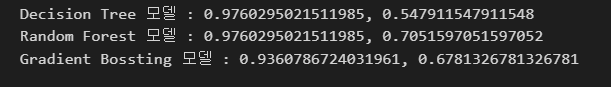


In [97]:
X_train, X_test, y_train, y_test \
    = train_test_split(train_data, train_target, test_size=0.2, stratify=train_target, random_state=42)

# 전처리
# RegexpTokenizer + stopwords + PorterStemmer
english_stops = set (stopwords.words('english'))
regtok = RegexpTokenizer(r"[\w']{3,}")
def custom_tokenizer(text):
    toks = regtok.tokenize(text.lower())
    toks = [t for t in toks if t not in english_stops]
    tokes = [PorterStemmer().stem(t) for t in toks]
    return tokes
tfidf_custom = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=2000, min_df = 5, max_df=0.5)
X_train_tfidf_c = tfidf_custom.fit_transform(X_train)
X_test_tfidf_c = tfidf_custom.transform(X_test)


c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [98]:
from sklearn.linear_model import LogisticRegression
lr_c = LogisticRegression(max_iter=1000)
lr_c.fit(X_train_tfidf_c, y_train)
print(lr_c.score(X_train_tfidf_c, y_train), lr_c.score(X_test_tfidf_c, y_test))

0.926859250153657 0.8058968058968059


In [104]:
# n-gram 실험 1,2 / 1,3
# 성능향상 기대
tfidf_12 = TfidfVectorizer(token_pattern=r"[\w']{3,}", 
                           stop_words= stopwords.words('english'),
                           ngram_range=(1,3), max_features=None,
                           min_df=2, max_df=0.5)
X_train_12 = tfidf_12.fit_transform(X_train)
X_test_12 = tfidf_12.transform(X_test)
X_train_12.shape

lr_c = LogisticRegression(max_iter=1000)
lr_c.fit(X_train_12, y_train)
print(lr_c.score(X_train_12, y_train), lr_c.score(X_test_12, y_test))


0.9637369391518131 0.828009828009828


In [107]:
# 한국어 처리 konlpy
# 품사기반 태깅 tokenizer Noun Verb Adjective
# 데이터 로딩
import pandas as pd
url = "https://drive.google.com/uc?id=1KOKgZ4qCg49bgj1QNTwk1Vd29soeB27o"
df = pd.read_csv(url)
df.head()

,review,rating,date,title
0,돈 들인건 티가 나지만 보는 내내 하품만,1,2018.10.29,인피니티 워
1,몰입할수밖에 없다. 어렵게 생각할 필요없다. 내가 전투에 참여한듯 손에 땀이남.,10,2018.10.26,인피니티 워
2,이전 작품에 비해 더 화려하고 스케일도 커졌지만.... 전국 맛집의 음식들을 한데 ...,8,2018.10.24,인피니티 워
3,이 정도면 볼만하다고 할 수 있음!,8,2018.10.22,인피니티 워
4,재미있다,10,2018.10.20,인피니티 워


In [108]:
df.title.unique()  #==> class로 보자

array(['인피니티 워', '라라랜드', '곤지암', '신과함께', '범죄도시', '택시운전사', '코코'],
      dtype=object)

In [110]:
X_train, X_test, y_train, y_test \
    = train_test_split(df.review, df.title, stratify=df.title, random_state=42, test_size=0.2)

from konlpy.tag import Okt
okt = Okt()

In [111]:
# simple version
tfidf = TfidfVectorizer(tokenizer=okt.nouns, max_features=2000, min_df=5, max_df=0.5)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)
print (clf.score(X_train_tfidf, y_train), clf.score (X_test_tfidf, y_test))

c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7574702886247878 0.6896434634974533


In [112]:
def custom_tokenizer(text):
    target = ['Noun', 'Verb', 'Adjective']
    return [w for w, tag in okt.pos(text, norm=True, stem=True) if tag in target]

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=2000, min_df=5, max_df=0.5)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)
print (clf.score(X_train_tfidf, y_train), clf.score (X_test_tfidf, y_test))

c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7824278438030561 0.7144312393887946
